## Bandits in Pytorch

In [60]:
import torch
import math
import matplotlib.pyplot as plt
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


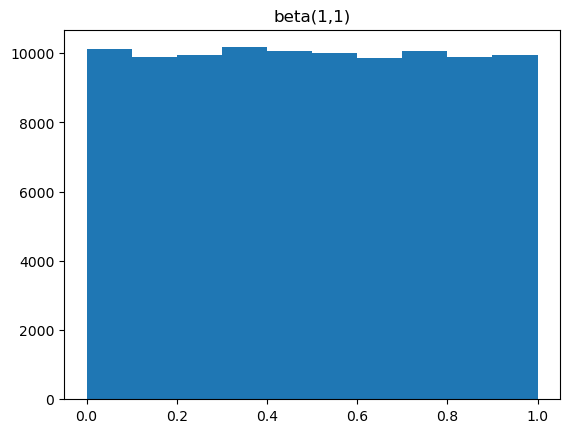

In [61]:
beta1 = torch.distributions.beta.Beta(1,1)
samples1 = [beta1.sample() for _ in range(100_000)]
plt.hist(samples1, range=[0, 1], bins=10)
plt.title('beta(1,1)')
plt.show()

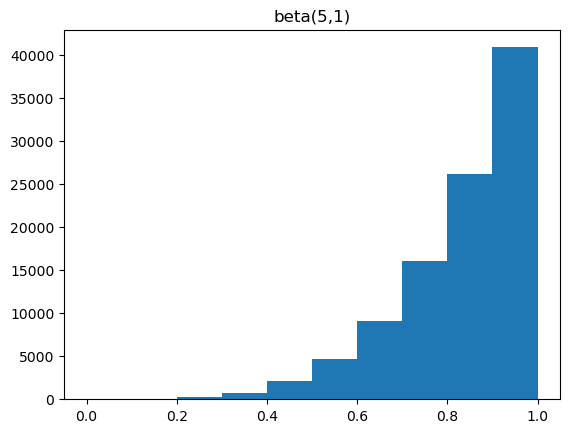

In [62]:
beta2 = torch.distributions.beta.Beta(5,1)
samples2 = [beta2.sample() for _ in range(100_000)]
plt.hist(samples2, range=[0,1], bins=10)
plt.title('beta(5,1)')
plt.show()

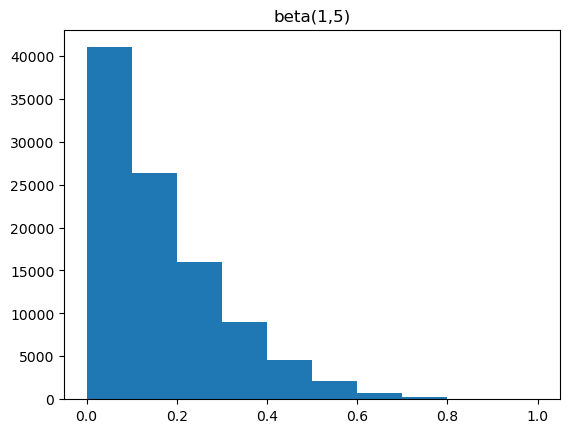

In [63]:
beta3 = torch.distributions.beta.Beta(1,5)
samples3 = [beta3.sample() for _ in range(100_000)]
plt.hist(samples3, range=[0,1], bins=10)
plt.title('beta(1,5)')
plt.show()

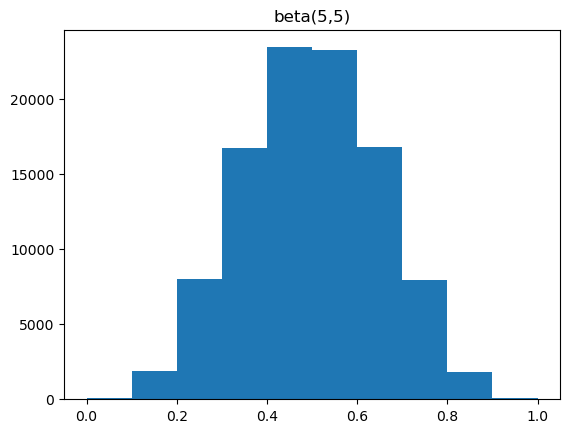

In [64]:
beta4 = torch.distributions.beta.Beta(5,5)
samples4 = [beta4.sample() for _ in range(100_000)]
plt.hist(samples4, range=[0,1], bins=10)
plt.title('beta(5,5)')
plt.show()

## Set up BanditEnv and run episodes

In [65]:
from multi_armed_bandit import BanditEnv

bandit_payout = [0.1, 0.15, 0.3]
bandit_reward = [4, 3, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

In [ ]:
def random_policy():
    action = torch.multinomial(torch.ones(n_action), 1).item()
    return action

In [66]:
n_episode = 100_000
n_action = len(bandit_payout)
action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]

In [68]:
for episode in range(n_episode):
    action = random_policy()
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    for a in range(n_action):
        if action_count[a]:
            action_avg_reward[a].append(
                action_total_reward[a]/action_count[a])
        else:
            action_avg_reward[a].append(0)

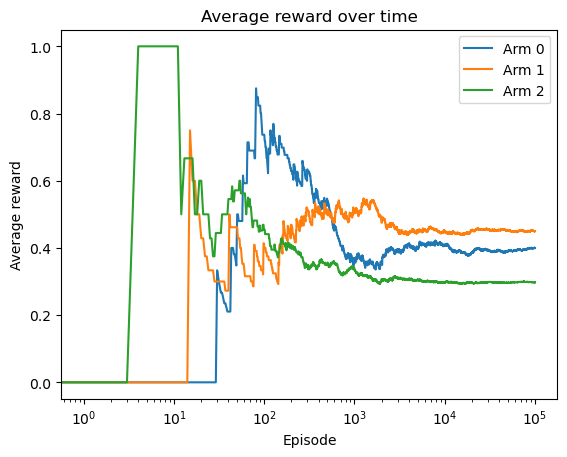

In [69]:
for action in range(n_action):
    plt.plot(action_avg_reward[action])
plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.title('Average reward over time')
plt.xscale('log')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

In [70]:
[round(bandit_payout[i] * bandit_reward[i],2) for i in range(len(bandit_payout))]

[0.4, 0.45, 0.3]

## Epsilon Greedy Algorithm

In [ ]:
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(Q):
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

epsilon = 0.2
epsilon_greedy_policy = gen_epsilon_greedy_policy(n_action, epsilon)

In [71]:
n_episode = 100_000
n_action = len(bandit_payout)
action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]
Q = torch.zeros(n_action)

In [73]:
for epsiode in range(n_episode):
    action = epsilon_greedy_policy(Q)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for a in range(n_action):
        if action_count[a] > 0:
            action_avg_reward[a].append(
                action_total_reward[a]/action_count[a]
            )
        else:
            action_avg_reward[a].append(0)

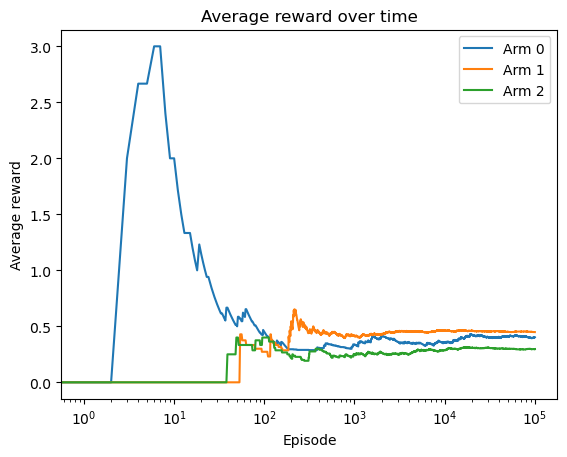

In [74]:
for action in range(n_action):
    plt.plot(action_avg_reward[action])
plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.title('Average reward over time')
plt.xscale('log')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

## Softmax Exploration

In [ ]:
def gen_softmax_exploration_policy(tau):
    def policy_function(Q):
        probs = torch.exp(Q / tau)
        probs = probs / torch.sum(probs)
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function
tau = 0.1
softmax_exploration_policy = gen_softmax_exploration_policy(tau)

In [75]:
n_episode = 100_000
n_action = len(bandit_payout)
action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]
Q = torch.zeros(n_action)

In [58]:
for epsiode in range(n_episode):
    action = softmax_exploration_policy(Q)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for a in range(n_action):
        if action_count[a] > 0:
            action_avg_reward[a].append(
                action_total_reward[a]/action_count[a]
            )
        else:
            action_avg_reward[a].append(0)

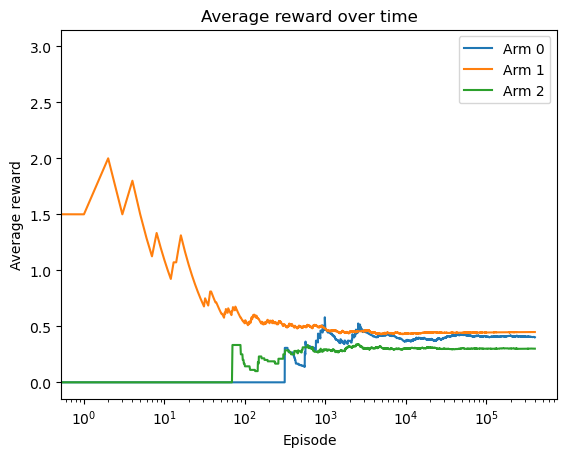

In [59]:
for action in range(n_action):
    plt.plot(action_avg_reward[action])
plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.title('Average reward over time')
plt.xscale('log')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()

## Uppder Confidenc Bound (UCB)

In [80]:
def upper_confidence_bound(Q, action_count, t):
    ucb = torch.sqrt((2 * torch.log(torch.tensor(float(t)))) / 
                    action_count) + Q
    return torch.argmax(ucb).item()

In [91]:
# torch.tensor(float(episode))/torch.tensor(action_count) + Q
Q

tensor([0.4034, 0.4486, 0.2962])

In [81]:
n_episode = 100_000
n_action = len(bandit_payout)
action_count = [0 for _ in range(n_action)]
action_total_reward = [0 for _ in range(n_action)]
action_avg_reward = [[] for action in range(n_action)]
Q = torch.zeros(n_action)

In [82]:
for epsiode in range(n_episode):
    action = upper_confidence_bound(Q, action_count, epsiode)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_total_reward[action] += reward
    Q[action] = action_total_reward[action] / action_count[action]
    for a in range(n_action):
        if action_count[a] > 0:
            action_avg_reward[a].append(
                action_total_reward[a]/action_count[a]
            )
        else:
            action_avg_reward[a].append(0)

TypeError: unsupported operand type(s) for /: 'Tensor' and 'list'

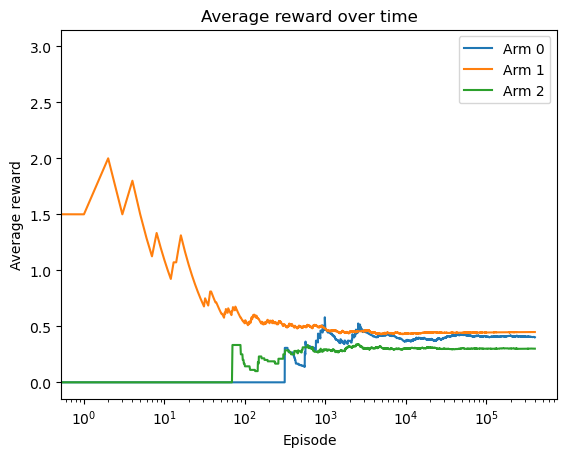

In [ ]:
for action in range(n_action):
    plt.plot(action_avg_reward[action])
plt.legend(['Arm {}'.format(action) for action in range(n_action)])
plt.title('Average reward over time')
plt.xscale('log')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.show()